[Table of Contents](./table_of_contents.ipynb)

In [ ]:
#!python -m pip install filterpy 
#!conda config --add channels conda-forge
!conda install filterpy
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [ ]:
!y

# Preface

In [77]:
from __future__ import division, print_function
%matplotlib inline

In [78]:
import filterpy 
import sympy

ModuleNotFoundError: No module named 'filterpy'

In [45]:
#format the book
import book_format
book_format.set_style()

Please install FilterPy from the command line by running the command
	$ pip install filterpy

See chapter 0 for instructions.
Please install SymPy before continuing. See chapter 0 for instructions.


UnboundLocalError: local variable 'filterpy' referenced before assignment

Introductory textbook for Kalman filters and Bayesian filters. The book is written using Jupyter Notebook so you may read the book in your browser and also run and modify the code, seeing the results inside the book. What better way to learn?
卡尔曼滤波器和贝叶斯滤波器入门教材。该书是使用Jupyter Notebook编写的，因此您可以在浏览器中阅读该书，还可以运行和修改代码，以查看书中的结果。有什么更好的学习方法

## Kalman and Bayesian Filters  卡尔曼和贝叶斯滤波器 

Sensors are noisy. The world is full of data and events that we want to measure and track, but we cannot rely on sensors to give us perfect information. The GPS in my car reports altitude. Each time I pass the same point in the road it reports a slightly different altitude. My kitchen scale gives me different readings if I weigh the same object twice.
传感器噪声。世界上充满了我们想要测量和跟踪的数据和事件，但是我们不能依靠传感器来提供完美的信息。我车上的GPS报告高度。每当我经过道路上的同一点时，都会报告高度略有不同。如果我两次称量相同的物体，我的厨房秤会给我不同的读数。

In simple cases the solution is obvious. If my scale gives slightly different readings I can just take a few readings and average them. Or I can replace it with a more accurate scale. But what do we do when the sensor is very noisy, or the environment makes data collection difficult? We may be trying to track the movement of a low flying aircraft. We may want to create an autopilot for a drone, or ensure that our farm tractor seeded the entire field. I work on computer vision, and I need to track moving objects in images, and the computer vision algorithms create very noisy and unreliable results. 
在简单的情况下，解决方案是显而易见的。如果我的秤给出的读数略有不同，我可以取几个读数并取平均值。或者我可以用更准确的比例代替它。但是，当传感器噪声很大或环境使数据收集变得困难时，我们该怎么办？我们可能正在尝试跟踪低速飞行的飞机的运动。我们可能想为无人机创建自动驾驶仪，或者确保我们的农用拖拉机在整个田间播种。我从事计算机视觉方面的工作，需要跟踪图像中的移动对象，因此计算机视觉算法会产生非常嘈杂且不可靠的结果。


This book teaches you how to solve these sorts of filtering problems. I use many different algorithms, but they are all based on *Bayesian probability*. In simple terms Bayesian probability determines what is likely to be true based on past information. 

If I asked you the heading of my car at this moment you would have no idea. You'd proffer a number between 1$^\circ$ and 360$^\circ$ degrees, and have a 1 in 360 chance of being right. Now suppose I told you that 2 seconds ago its heading was 243$^\circ$. In 2 seconds my car could not turn very far so you could make a far more accurate prediction. You are using past information to more accurately infer information about the present or future. 

The world is also noisy. That prediction helps you make a better estimate, but it also subject to noise. I may have just braked for a dog or swerved around a pothole. Strong winds and ice on the road  are external influences on the path of my car. In control literature we call this *noise* though you may not think of it that way. 

There is more to Bayesian probability, but you have the main idea. Knowledge is uncertain, and we alter our beliefs based on the strength of the evidence. Kalman and Bayesian filters blend our noisy and limited knowledge of how a system behaves with the noisy and limited sensor readings to produce the best possible estimate of the state of the system. Our principle is to never discard information. 

Say we are tracking an object and a sensor reports that it suddenly changed direction. Did it really turn, or is the data noisy? It depends. If this is a jet fighter we'd be very inclined to believe the report of a sudden maneuver. If it is a freight train on a straight track we would discount it. We'd further modify our belief depending on how accurate the sensor is. Our beliefs depend on the past and on our knowledge of the system we are tracking and on the characteristics of the sensors. 

The Kalman filter was invented by Rudolf Emil Kálmán to solve this sort of problem in a mathematically optimal way. Its first use was on the Apollo missions to the moon, and since then it has been used in an enormous variety of domains. There are Kalman filters in aircraft, on submarines, and on cruise missiles. Wall street uses them to track the market. They are used in robots, in IoT (Internet of Things) sensors, and in laboratory instruments. Chemical plants use them to control and monitor reactions. They are used to perform medical imaging and to remove noise from cardiac signals. If it involves a sensor and/or time-series data, a Kalman filter or a close relative to the Kalman filter is usually involved.

## Motivation for this Book 这本书的动机

I'm a software engineer that spent almost two decades in aerospace, and so I have always been 'bumping elbows' with the Kalman filter, but never implemented one. They've always had a fearsome reputation for difficulty. The theory is beautiful, but quite difficult to learn if you are not already well trained in topics such as signal processing, control theory, probability and statistics, and guidance and control theory. As I moved into solving tracking problems with computer vision the need to implement them myself became urgent.   
我是一名软件工程师，在航空航天领域花费了将近20年，因此我一直都在使用Kalman滤波器“弯头”，但从未实现过。他们总是因困难而声名狼藉。该理论很漂亮，但是如果您还没有在信号处理，控制理论，概率和统计以及指导和控制理论等主题上受过良好训练，则很难学习。随着我着手解决计算机视觉的跟踪问题，迫切需要自己实施这些问题。


There are excellent textbooks in the field, such as Grewal and Andrew's *Kalman Filtering*. But sitting down and trying to read many of these books is a dismal and trying experience if you do not have the necessary background. Typically the first few chapters fly through several years of undergraduate math, blithely referring you to textbooks on Itō calculus, and presenting an entire semester's worth of statistics in a few brief paragraphs. They are textbooks for an upper undergraduate  or graduate level course, and an invaluable reference to researchers and professionals, but the going is truly difficult for the more casual reader. Notation is introduced without explanation, different texts use different words and variable names for the same concept, and the books are almost devoid of examples or worked problems. I often found myself able to parse the words and comprehend the mathematics of a definition, but had no idea as to what real world phenomena these words and math were attempting to describe. "But what does that *mean?*" was my repeated thought. Here are typical examples which once puzzled me:   
该领域有许多优秀的教科书，例如Grewal和Andrew的Kalman滤波。但是，如果您没有必要的背景知识，那么坐下来尝试阅读其中许多书籍是一种令人沮丧的尝试体验。通常，前几章会讲解数年的本科数学知识，愉快地带您参考有关伊藤微积分的教科书，并在几段简短的段落中介绍整个学期的统计价值。它们是高等本科生或研究生课程的教科书，是研究人员和专业人员的宝贵参考，但是对于那些比较随意的读者而言，这确实很难。引入符号时没有任何解释，不同的文本为相同的概念使用不同的词和变量名，并且这些书几乎没有示例或已解决的问题。我经常发现自己能够解析这些单词并理解定义的数学原理，但是却不知道这些单词和数学试图描述什么现实世界的现象。 “但是，这是什么意思？”是我的反复思考。以下是曾经让我感到困惑的典型示例：

$$\begin{aligned}\hat{x}_{k} = \Phi_{k}\hat{x}_{k-1} + G_k u_{k-1} + K_k [z_k - H \Phi_{k} \hat{x}_{k-1} - H G_k u_{k-1}]
\\ 
\mathbf{P}_{k\mid k} = (I - \mathbf{K}_k \mathbf{H}_{k})\textrm{cov}(\mathbf{x}_k - \hat{\mathbf{x}}_{k\mid k-1})(I - \mathbf{K}_k \mathbf{H}_{k})^{\text{T}}  + \mathbf{K}_k\textrm{cov}(\mathbf{v}_k )\mathbf{K}_k^{\text{T}}\end{aligned}$$

However, as I began to finally understand the Kalman filter I realized the underlying concepts are quite straightforward. If you know a few simple probability rules, and have some intuition about how we fuse uncertain knowledge, the concepts of the Kalman filter are accessible. Kalman filters have a reputation for difficulty, but shorn of much of the formal terminology the beauty of the subject and of their math became clear to me, and I fell in love with the topic.    
但是，当我最终了解卡尔曼滤波器时，我意识到基本概念非常简单。如果您了解一些简单的概率规则，并且对我们如何融合不确定性知识有一些直觉，那么就可以使用卡尔曼滤波器的概念。卡尔曼过滤器因其困难而享有盛誉，但是在很多正式术语中，对主题和它们的数学之美的了解对我来说是显而易见的，我爱上了这个主题。

As I began to understand the math and theory more difficulties appeared. A book or paper will make some statement of fact and presents a graph as proof.  Unfortunately, why the statement is true is not clear to me, or I cannot reproduce the plot. Or maybe I wonder "is this true if R=0?"  Or the author provides pseudocode at such a high level that the implementation is not obvious. Some books offer Matlab code, but I do not have a license to that expensive package. Finally, many books end each chapter with many useful exercises. Exercises which you need to understand if you want to implement Kalman filters for yourself, but exercises with no answers. If you are using the book in a classroom, perhaps this is okay, but it is terrible for the independent reader. I loathe that an author withholds information from me, presumably to avoid 'cheating' by the student in the classroom.   
当我开始理解数学和理论时，出现了更多的困难。一本书或一本书将陈述事实，并提出图表作为证明。不幸的是，为什么陈述正确，我还是不清楚，否则我无法复制情节。也许我想知道“如果R = 0，这是真的吗？”或者作者提供了很高的伪代码，以至于实现起来并不明显。有些书提供了Matlab代码，但我没有该昂贵软件包的许可证。最后，许多书籍在每一章的末尾都有许多有用的练习。如果您想自己实现卡尔曼滤波器，则需要了解一些练习，但是这些练习没有答案。如果您在教室里使用这本书，也许可以，但是对于独立读者来说，这太糟糕了。我讨厌作者隐瞒我的信息，大概是为了避免教室里的学生“作弊”。

All of this impedes learning. I want to track an image on a screen, or write some code for my Arduino project. I want to know how the plots in the book are made, and to choose different parameters than the author chose. I want to run simulations. I want to inject more noise into the signal and see how a filter performs. There are thousands of opportunities for using Kalman filters in everyday code, and yet this fairly straightforward topic is the provenance of rocket scientists and academics.  
所有这些都阻碍了学习。我想跟踪屏幕上的图像，或者为我的Arduino项目编写一些代码。我想知道本书中的绘图是如何制作的，并选择与作者选择的参数不同的参数。我想运行模拟。我想给信号注入更多的噪声，看看滤波器的性能如何。在日常代码中使用卡尔曼滤波器有成千上万的机会，但是这个相当简单的话题是火箭科学家和学者的来历。

I wrote this book to address all of those needs. This is not the sole book for you if you design military radars. Go get a Masters or PhD at a great STEM school, because you'll need it. This book is for the hobbyist, the curious, and the working engineer that needs to filter or smooth data. If you are a hobbyist this book should provide everything you need. If you are serious about Kalman filters you'll need more. My intention is to introduce enough of the concepts and mathematics to make the textbooks and papers approachable.  
我写这本书是为了解决所有这些需求。如果您设计军用雷达，那么这不是唯一的书。去一所优秀的STEM学校获得硕士学位或博士学位，因为您需要它。本书适用于需要过滤或平滑数据的爱好者，好奇心和工作工程师。如果您是业余爱好者，这本书应该提供您所需要的一切。如果您对卡尔曼滤波器很认真，那么您将需要更多。我的目的是介绍足够的概念和数学，以使教科书和论文更容易上手。

This book is interactive. While you can read it online as static content, I urge you to use it as intended. It is written using Jupyter Notebook. This allows me to combine text, math, Python, and Python output in one place. Every plot, every piece of data in this book is generated from Python inside the notebook. Want to double the value of a parameter? Just change the parameter's value, and press CTRL-ENTER. A new plot or printed output will appear.   
这本书是互动的。虽然您可以在线阅读它作为静态内容，但我还是建议您按预期使用它。它是使用Jupyter Notebook编写的。这使我可以在一个地方组合文本，数学，Python和Python输出。本书中的每个图，每条数据都是从笔记本中的Python生成的。是否想将参数值加倍？只需更改参数的值，然后按CTRL-ENTER。将会出现一个新的绘图或打印输出。

This book has exercises, but it also has the answers. I trust you. If you just need an answer, go ahead and read the answer. If you want to internalize this knowledge, try to implement the exercise before you read the answer. Since the book is interactive, you enter and run your solution inside the book - you don't have to move to a different environment, or deal with importing a bunch of stuff before starting.  
这本书有练习，但也有答案。我信任你。如果您只需要一个答案，请继续阅读该答案。如果您想内化这些知识，请在阅读答案之前尝试实施本练习。由于本书是交互式的，因此您可以在本书中输入并运行您的解决方案-无需迁移到其他环境，也不必在开始之前处理大量工作。

This book is free. I've spent several thousand dollars on Kalman filtering books. I cannot believe they are within the reach of someone in a depressed economy or a financially struggling student. I have gained so much from free software like Python, and free books like those from Allen B. Downey  [1]. It's time to repay that. So, the book is free, it is hosted on free servers at GitHub, and it uses only free and open software such as IPython and MathJax.  
这本书是免费的。我花了几千美元在卡尔曼过滤书籍上。我不敢相信他们在经济不景气或经济困难的学生中无法承受。我从免费软件（如Python）和免费书籍（如Allen B. Downey [1]）中受益匪浅。现在该偿还了。因此，该书是免费的，它托管在GitHub的免费服务器上，并且仅使用IPython和MathJax等免费开放软件。

## Reading Online

<b>GitHub</b>

The book is hosted on GitHub, and you can read any chapter by clicking on its name. GitHub statically renders Jupyter Notebooks. You will not be able to run or alter the code, but you can read all of the content.
这本书托管在GitHub上，您可以通过单击其名称来阅读任何章节。 GitHub静态地呈现Jupyter Notebooks。您将无法运行或更改代码，但是您可以阅读所有内容。

The GitHub pages for this project are at

    https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python 


<b>binder</b>

binder serves interactive notebooks online, so you can run the code and change the code within your browser without downloading the book or installing Jupyter. Use this link to access the book via binder:  
活页夹为在线交互式笔记本提供服务，因此您无需下载书籍或安装Jupyter，即可运行代码并在浏览器中更改代码。使用此链接可通过活页夹访问图书：

    http://mybinder.org/repo/rlabbe/Kalman-and-Bayesian-Filters-in-Python

<b>nbviewer</b>

The nbviewer website will render any Notebook in a static format. I find it does a slightly better job than the GitHub renderer, but it is slighty harder to use. It accesses GitHub directly; whatever I have checked into GitHub will be rendered by nbviewer.   
nbviewer网站将以静态格式呈现任何笔记本。我发现它比GitHub渲染器做得更好，但是使用起来有点困难。它直接访问GitHub；我签入GitHub的所有内容都将由nbviewer呈现。

You may access this book via nbviewer here:

http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb

## PDF Version

I periodically generate a PDF of the book from the notebooks. You can access it here:

https://drive.google.com/file/d/0By_SW19c1BfhSVFzNHc0SjduNzg/view?usp=sharing

## Downloading and Running the Book  下载并运行书

However, this book is intended to be interactive and I recommend using it in that form. It's a little more effort to set up, but worth it. If you install IPython and some supporting libraries  on your computer and then clone this book you will be able to run all of the code in the book yourself. You can perform experiments, see how filters react to different data, see how different filters react to the same data, and so on. I find this sort of immediate feedback both vital and invigorating. You do not have to wonder "what happens if". Try it and see!   
但是，本书打算是交互式的，我建议以这种形式使用。设置起来需要付出更多的努力，但值得。如果您在计算机上安装了IPython和一些支持库，然后克隆了这本书，您将能够自己运行书中的所有代码。您可以执行实验，查看过滤器如何对不同的数据做出反应，查看不同的过滤器如何对同一数据做出反应等等。我发现这种即时反馈至关重要且令人振奋。您不必怀疑“如果发生什么情况”。试试看！

安装说明可在安装附录中找到。
Instructions for installation can be found in the Installation appendix, found [here]
(http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Appendix-A-Installation.ipynb).

Once the software is installed you can navigate to the installation directory and run Juptyer notebook with the command line instruction   
安装软件后，您可以导航到安装目录并使用命令行指令运行Juptyer Notebook

    jupyter notebook

This will open a browser window showing the contents of the base directory. The book is organized into chapters. Each chapter is named *xx*-*name*.ipynb, where *xx* is the chapter number. .ipynb is the Notebook file extension. To read Chapter 2, click on the link for chapter 2. This will cause the browser to open that subdirectory. In each subdirectory there will be one or more IPython Notebooks (all notebooks have a .ipynb file extension). The chapter contents are in the notebook with the same name as the chapter name. There are sometimes supporting notebooks for doing things like generating animations that are displayed in the chapter. These are not intended to be read by the end user, but of course if you are curious as to how an animation is made go ahead and take a look.   
这将打开一个浏览器窗口，显示基本目录的内容。这本书分为几章。每个章节都被命名为* xx *-* name * .ipynb，其中* xx *是章节编号。 .ipynb是Notebook文件的扩展名。要阅读第2章，请单击第2章的链接。这将导致浏览器打开该子目录。在每个子目录中，将有一个或多个IPython Notebook（所有笔记本均具有.ipynb文件扩展名）。章节内容在笔记本中，名称与章节名称相同。有时会有支持笔记本来做诸如生成本章中显示的动画之类的事情。最终用户不打算阅读这些内容，但是如果您对如何制作动画感到好奇，请继续阅读。

Admittedly this is a cumbersome interface to a book. I am following in the footsteps of several other projects that are re-purposing Jupyter Notebook to generate entire books. I feel the slight annoyances have a huge payoff - instead of having to download a separate code base and run it in an IDE while you try to read a book, all of the code and text is in one place. If you want to alter the code, you may do so and immediately see the effects of your change. If you find a bug, you can make a fix, and push it back to my repository so that everyone in the world benefits. And, of course, you will never encounter a problem I face all the time with traditional books - the book and the code are out of sync with each other, and you are left scratching your head as to which source to trust.  
诚然，这是一本书的繁琐接口。我正在跟随其他几个项目的脚步，这些项目正在重新使用Jupyter Notebook来生成整本书。我觉得这些烦恼会带来巨大的收益-不必在尝试阅读书时下载单独的代码库并在IDE中运行它，而所有代码和文本都放在一个位置。如果您想更改代码，则可以这样做，并立即查看所做更改的效果。如果发现错误，则可以进行修复，然后将其推回到我的存储库中，以使世界上的每个人都受益。而且，当然，您永远不会遇到传统书籍经常遇到的问题-书籍和代码彼此之间不同步，而您对于确定要信任的来源则犹豫不决。

## Jupyter

First, some words about using Jupyter Notebooks with this book. This book is interactive. If you want to run code examples, and especially if you want to see animated plots, you will need to run the code cells. I cannot teach you everything about Jupyter Notebooks. However, a few things trip readers up. You can go to http://jupyter.org/ for detailed documentation.
首先，关于在本书中使用Jupyter Notebooks的一些话。这本书是互动的。如果要运行代码示例，尤其是要查看动画图，则需要运行代码单元。我无法教您有关Jupyter笔记本的所有知识。但是，有一些事情使读者感到震惊。您可以访问http://jupyter.org/获取详细文档。

First, you must always run the topmost code cell, the one with the comment `#format the book`. It is directly above. This does not just set up formatting, which you might not care about, but it also loads some necessary modules and makes some global settings regarding plotting and printing. So, always run this cell unless you are just passively reading. 
首先，您必须始终运行最上面的代码单元，带有注释“ #format the book”的代码单元。它在上方。这不仅设置了您可能不关心的格式，而且还加载了一些必要的模块并进行了有关打印和打印的全局设置。因此，除非您只是被动地阅读，否则请始终运行此单元格。

The line

```python
%matplotlib inline
```
causes plots to be displayed inside the notebook. Matplotlib is a plotting package which is described below. For reasons I don't understand the default behavior of Jupyter Notebooks is to generate plots in an external window.   
％matplotlib内联 
Matplotlib是一个绘图软件包，如下所述。由于某些原因，我不了解Jupyter Notebook的默认行为是在外部窗口中生成图。

The percent sign in `%matplotlib` is used for IPython *magic* - these are commands to the kernel to do things that are not part of the Python language. There are many useful magic commands, and you can read about them here: http://ipython.readthedocs.io/en/stable/interactive/magics.html   
％matplotlib中的百分号用于IPython * magic *-这些是发给内核执行不属于Python语言一部分的操作的命令。有许多有用的魔术命令，您可以在此处阅读有关它们的信息：

Running the code inside a cell is easy. Click on it so that it has focus (a box will be drawn around it), and then press CTRL-Enter. 
在单元内运行代码很容易。单击它使其具有焦点（将在其周围绘制一个框），然后按CTRL-Enter

Second, cells must be run in order. I break problems up over several cells; if you try to just skip down and run the tenth code cell it almost certainly won't work. If you haven't run anything yet just choose *Run All Above* from the **Cell** menu item. That's the easiest way to ensure everything has been run.

Once cells are run you can often jump around and rerun cells in different orders, but not always. I'm trying to fix this, but there is a tradeoff. I'll define a variable in cell 10 (say), and then run code that modifies that variable in cells 11 and 12. If you go back and run cell 11 again the variable will have the value that was set in cell 12, and the code expects the value that was set in cell 10. So, occasionally you'll get weird results if you run cells out of order. My advise is to backtrack a bit, and run cells in order again to get back to a proper state. It's annoying, but the interactive aspect of Jupyter notebooks more than makes up for it. Better yet, submit an issue on GitHub so I know about the problem and fix it!

Finally, some readers have reported problems with the animated plotting features in some browsers. I have not been able to reproduce this. In parts of the book I use the `%matplotlib notebook` magic, which enables interactive plotting. If these plots are not working for you, try changing this to read `%matplotlib inline`. You will lose the animated plotting, but it seems to work on all platforms and browsers.

## SciPy, NumPy, and Matplotlib

SciPy is a open source collection of software for mathematics. Included in SciPy are NumPy, which provides array objects, linear algebra, random numbers, and more. Matplotlib provides plotting of NumPy arrays. SciPy's modules duplicate some of the functionality in NumPy while adding features such as optimization, image processing, and more.  
SciPy是用于数学的开源软件集合。 SciPy中包括NumPy，NumPy提供数组对象，线性代数，随机数等。 Matplotlib提供NumPy数组的绘图。 SciPy的模块复制了NumPy中的某些功能，同时添加了诸如优化，图像处理等功能。

To keep my efforts for this book managable I have elected to assume that you know how to program in Python, and that you also are familiar with these packages. Nonetheless, I will take a few moments to illustrate a few features of each; realistically you will have to find outside sources to teach you the details. The home page for SciPy, https://scipy.org, is the perfect starting point, though you will soon want to search for relevant tutorials and/or videos.
为了使本书的内容易于管理，我选择假定您知道如何使用Python进行编程，并且您也熟悉这些软件包。尽管如此，我将花一些时间来说明每个示例的一些功能。实际上，您将必须找到外部资源来教您详细信息。 SciPy主页（https://scipy.org）是一个完美的起点，尽管您很快就会想搜索相关的教程和/或视频。

NumPy, SciPy, and Matplotlib do not come with the default Python distribution; see the *Installation* Appendix if you do not have them installed.
NumPy，SciPy和Matplotlib不附带默认的Python发行版；请参见参考资料。如果尚未安装，请参阅*安装*附录。

I use NumPy's array data structure throughout the book, so let's learn about them now. I will teach you enough to get started; refer to NumPy's documentation if you want to become an expert.
在整本书中都使用NumPy的数组数据结构，所以现在让我们了解它们。我会教你足够的知识来开始。如果您想成为专家，请参阅NumPy的文档。

`numpy.array` implements a one or more dimensional array. Its type is `numpy.ndarray`, and we will refer to this as an ndarray for short. You can construct it with any list-like object. The following constructs a 1-D array from a list:  
numpy.array实现一个或多个维数组。它的类型是numpy.ndarray，我们简称为ndarray。您可以使用任何类似列表的对象来构造它。以下从列表构造一维数组：

In [46]:
import numpy as np
x = np.array([1, 2, 3])
print(type(x))
x

<class 'numpy.ndarray'>


array([1, 2, 3])

It has become a industry standard to use `import numpy as np`. 

You can also use tuples:

In [47]:
x = np.array((4,5,6))
x

array([4, 5, 6])

Create multidimensional arrays with nested brackets:

In [48]:
x = np.array([[1, 2, 3],
              [4, 5, 6]])
print(x)

[[1 2 3]
 [4 5 6]]


You can create arrays of 3 or more dimensions, but we have no need for that here, and so I will not elaborate.

By default the arrays use the data type of the values in the list; if there are multiple types then it will choose the type that most accurately represents all the values. So, for example, if your list contains a mix of `int` and `float` the data type of the array would be of type `float`. You can override this with the `dtype` parameter.

In [49]:
x = np.array([1, 2, 3], dtype=float)
print(x)

[1. 2. 3.]


您可以使用下标位置访问数组元素:

In [50]:
x = np.array([[1, 2, 3],
              [4, 5, 6]])

print(x[1,2])  # [第一维，第二维]第一维的下标为1的元素[4, 5, 6]，取该元素的下标为2的元素

6


python对象切片：  
1、正索引和负索引；  
2、对象[起始索引 ：终止索引 ：步幅]  
3、https://www.jianshu.com/p/15715d6f4dad  
4、>>>(0, 1, 2, 3, 4, 5)[:3] 元组的切片操作  
   #>>>(0, 1, 2)   
   
5、>>>'ABCDEFG'[::2]   字符串的切片操作
   #>>>'ACEG'
   
6、>>>a = [1,2,['A','B']]  
#>>>print('a={}'.format(a))  
#>>>b = a[:]  
#>>>b[0] = 9 #修改b的最外层元素，将1变成9  
#>>>b[2][0] = 'D' #修改b的内嵌层元素  
#>>>print('a={}'.format(a))  
#>>>print('b={}'.format(b))  
#>>>print('id(a)={}'.format(id(a)))  
#>>>print('id(b)={}'.format(id(b)))  
a=[1, 2, ['A', 'B']] #原始a  
a=[1, 2, ['D', 'B']] #b修改内部元素A为D后，a中的A也变成了D，说明共享内部嵌套元素，但外部元素1没变。  
b=[9, 2, ['D', 'B']] #修改后的b  
id(a)=38669128  
id(b)=38669192  


用作下标的 冒号(:) 是该行或该列中所有数据的简写:  

In [51]:
# x = ([[1, 2, 3], [4, 5, 6]]) 
x[:, 0]                  # [从起始索引0开始，到终止索引1，取下标为0的所有元素]

array([1, 4])

We can get the second row with:

In [52]:
x[1, :]                  # [从第一维的下标为1的元素[4, 5, 6]，取所有的元素]

array([4, 5, 6])

Get the last two elements of the second row with:

In [53]:
x[1, 1:]                 # [从第一维下标为1的元素[4, 5, 6]，从第二维下标为1的元素开始取，取到结尾]

array([5, 6])

As with Python `list`s, you can use negative indexes to refer to the end of the array. -1 refers to the last index. So another way to get the last two elements of the second (last) row would be:  
与Python`list`一样，您可以使用负索引来引用数组的末尾。 -1表示最后一个索引。因此，获取第二（最后）行的最后两个元素的另一种方法是：

In [54]:
# 第一维：-2         -1  
# 第二维：-3 -2 -1   -3 -2 -1       
# x = ([[1, 2, 3], [4, 5, 6]]) 
x[-1, -2:]

array([5, 6])

You can perform matrix addition with the `+` operator, but matrix multiplication requires the `dot` method or function. The `*` operator performs element-wise multiplication, which is **not** what you want for linear algebra.

In [55]:
x = np.array([[1., 2.],
              [3., 4.]])
print('addition:\n', x + x)
print('\nelement-wise multiplication\n', x * x)
print('\nmultiplication\n', np.dot(x, x))
print('\ndot is also a member of np.array\n', x.dot(x))

addition:
 [[2. 4.]
 [6. 8.]]

element-wise multiplication
 [[ 1.  4.]
 [ 9. 16.]]

multiplication
 [[ 7. 10.]
 [15. 22.]]

dot is also a member of np.array
 [[ 7. 10.]
 [15. 22.]]


Python 3.5 introduced the `@` operator for matrix multiplication.  
Python 3.5引入了@运算符用于矩阵点乘法。

In [56]:
x @ x

array([[ 7., 10.],
       [15., 22.]])

This will only work if you are using Python 3.5+. This book requires 3.6 or later, so I will use it whenever I can. Note that the operator requires that both values are arrays. Hence, `x @ 3.` raises a ValueError whereas `np.dot(X, 3.)` works fine.  
仅当您使用Python 3.5+时，这才有效。本书要求3.6或更高版本，因此我将尽可能使用它。请注意，运算符要求两个值都是数组。因此，`x @ 3.`引发ValueError，而`np.dot（X，3.）`可以正常工作。

You can get the transpose with `.T`, and the inverse with `numpy.linalg.inv`. The SciPy package also provides the inverse function.  
您可以使用.T来获取转置，使用numpy.linalg.inv来获取反置。 SciPy包还提供反函数。

In [57]:
# x = np.array([[1., 2.], [3., 4.]])
import scipy.linalg as linalg
print('transpose\n', x.T)
print('\nNumPy ninverse\n', np.linalg.inv(x))
print('\nSciPy inverse\n', linalg.inv(x))
print('unit matrix =\n', np.dot(x, np.linalg.inv(x)))

transpose
 [[1. 3.]
 [2. 4.]]

NumPy ninverse
 [[-2.   1. ]
 [ 1.5 -0.5]]

SciPy inverse
 [[-2.   1. ]
 [ 1.5 -0.5]]
unit matrix =
 [[1.0000000e+00 0.0000000e+00]
 [8.8817842e-16 1.0000000e+00]]


There are helper functions like `zeros` to create a matrix of all zeros, `ones` to get all ones, and `eye` to get the identity matrix. If you want a multidimensional array, use a tuple to specify the shape.  
有一些辅助功能，例如“零”创建全零矩阵，“一”获取全零，以及“眼睛”获取标识矩阵。如果要使用多维数组，请使用元组指定形状。

In [58]:
print('zeros\n', np.zeros(7))
print('\nzeros(3x2)\n', np.zeros((3, 2)))
print('\neye\n', np.eye(3))
print('\n4x4-eye\n', np.eye(4))

zeros
 [0. 0. 0. 0. 0. 0. 0.]

zeros(3x2)
 [[0. 0.]
 [0. 0.]
 [0. 0.]]

eye
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

4x4-eye
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


We have functions to create equally spaced data. `arange` works much like Python's `range` function, except it returns a NumPy array. `linspace` works slightly differently, you call it with `linspace(start, stop, num)`, where `num` is the length of the array that you want.  
我们具有创建等距数据的功能。 `arange`的工作原理与Python的`range`函数非常相似，只是它返回一个NumPy数组。 linspace的工作方式略有不同，您可以使用linspace（start，stop，num）来调用它，其中num是您想要的数组的长度。

In [59]:
np.arange(0, 2, 0.1)        # (开始数值，结束数值，增长幅度)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [60]:
np.linspace(0, 2, 20)       # (开始数值，结束数值，数组长度)

array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])

Now let's plot some data. For the most part it is very simple. Matplotlib contains a plotting library `pyplot`. It is industry standard to import it as `plt`. Once imported, plot numbers by calling `plt.plot` with a list or array of numbers. If you make multiple calls it will plot multiple series, each with a different color.  
现在让我们绘制一些数据。在大多数情况下，这非常简单。 Matplotlib包含一个绘图库`pyplot`。将其导入为`plt'是行业标准。导入后，通过使用数字列表或数字数组调用`plt.plot`来绘制数字。如果您多次调用，它将绘制多个系列，每个系列都有不同的颜色

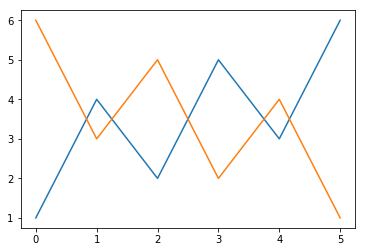

In [61]:
import matplotlib.pyplot as plt
a = np.array([6, 3, 5, 2, 4, 1])
plt.plot([1, 4, 2, 5, 3, 6])
plt.plot(a)

The output `[<matplotlib.lines.Line2D at 0x2ba160bed68>]` is because `plt.plot` returns the object that was just created. Ordinarily we do not want to see that, so I add a `;` to my last plotting command to suppress that output.  
输出`[<matplotlib.lines.Line2D at 0x2ba160bed68>]`是因为`plt.plot`返回刚刚创建的对象。通常我们不想看到它，因此我在最后一个绘图
命令中添加了“;”来抑制该输出。

By default `plot` assumes that the x-series is incremented by one. You can provide your own x-series by passing in both x and y.  
默认情况下，“ plot”假定x系列增加1。您可以通过传递x和y来提供自己的x系列。

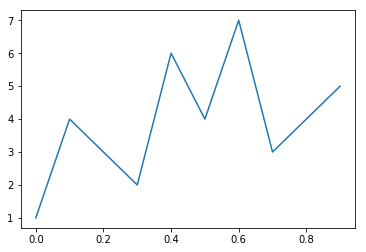

In [62]:
plt.plot(np.arange(0,1, 0.1), [1,4,3,2,6,4,7,3,4,5]);

There are many more features to these packages which I use in this book. Normally I will introduce them without explanation, trusting that you can infer the usage from context, or search online for an explanation. As always, if you are unsure, create a new cell in the Notebook or fire up a Python console and experiment!  
我在本书中使用了这些软件包的更多功能。通常，我会在不加解释的情况下介绍它们，并相信您可以从上下文中推断出用法，也可以在线搜索解释。与往常一样，如果不确定，请在Notebook中创建一个新单元格或启动一个Python控制台并进行实验！

### Exercise -  Create arrays  练习-创建数组

I want you to create a NumPy array of 10 elements with each element containing 1/10. There are several ways to do this; try to implement as many as you can think of.   
我希望您创建一个包含10个元素的NumPy数组，每个元素包含1/10。做这件事有很多种方法;尝试实现尽可能多的想法。


In [68]:
# your solution
print(np.ones(10) / 10.0)
print(np.array([.1, .1, .1, .1, .1, .1, .1, .1, .1, .1]))
print(np.array([.1]*10))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


### Solution

Here are three ways to do this. The first one is the one I want you to know. I used the '/' operator to divide all of the elements of the array with 10. We will shortly use this to convert the units of an array from meters to km.  
这是执行此操作的三种方法。第一个是我想让你知道的。我使用'/'运算符将数组的所有元素除以10。我们将很快使用它来将数组的单位从米转换为km。

In [36]:
print(np.ones(10) / 10.)
print(np.array([.1, .1, .1, .1, .1, .1, .1, .1, .1, .1]))
print(np.array([.1] * 10))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


Here is one I haven't covered yet. The function `numpy.asarray()` will convert its argument to an ndarray if it isn't already one. If it is, the data is unchanged. This is a handy way to write a function that can accept either Python lists or ndarrays, and it is very efficient if the type is already ndarray as nothing new is created.  
这是我尚未讲过的。函数numpy.asarray（）如果尚未将其参数转换为ndarray，则将其转换为ndarray。如果是，则数据不变。这是编写可以接受Python列表或ndarrays的函数的一种便捷方法，并且如果类型已经是ndarray，因为没有创建任何新内容，这将非常有效。

In [73]:
def one_tenth(x):
    print("x = ", type(x))
    x = np.asarray(x)
    print("np.asarray = ", type(x))
    return x / 10.

print(one_tenth([1, 2, 3]))            # I work!
print(one_tenth(np.array([4, 5, 6])))  # so do I!

x =  <class 'list'>
np.asarray =  <class 'numpy.ndarray'>
[0.1 0.2 0.3]
x =  <class 'numpy.ndarray'>
np.asarray =  <class 'numpy.ndarray'>
[0.4 0.5 0.6]


## Companion Software  配套软件

I am writing an open source Bayesian filtering Python library called FilterPy. Installation instructions are given above.  
我正在编写一个称为FilterPy的开源贝叶斯过滤Python库。上面给出了安装说明。

FilterPy is hosted GitHub at (https://github.com/rlabbe/filterpy) but the `pip` installed version should serve your needs.  
FilterPy托管在GitHub（https://github.com/rlabbe/filterpy）上，但是安装了`pip`版本应该可以满足您的需求。

Code that is specific to the book is stored with the book in the subdirectory **/kf_book**. It contains code for formatting the book. It also contains python files with names like *xxx*_internal.py. I use these to store functions that are useful for a specific chapter. This allows me to hide Python code that is not particularly interesting to read - I may be generating a plot or chart, and I want you to focus on the contents of the chart, not the mechanics of how I generate that chart with Python. If you are curious as to the mechanics of that, just go and browse the source. 
书籍专用的代码与书籍一起存储在子目录** / kf_book **中。它包含用于格式化书籍的代码。它还包含名称为* xxx * _internal.py的python文件。我用它们来存储对特定章节有用的功能。这使我可以隐藏阅读起来并不特别有趣的Python代码-我可能正在生成图形或图表，并且我希望您专注于图表的内容，而不是我用Python生成该图表的机制。如果您对这种机制感到好奇，那就去浏览源代码。

Some chapters introduce functions that are useful for the rest of the book. Those functions are initially defined within the Notebook itself, but the code is also stored in a Python file in **/kf_book** that is imported if needed in later chapters. I do document when I do this where the function is first defined, but this is still a work in progress. I try to avoid this because then I always face the issue of code in the directory becoming out of sync with the code in the book. However, Jupyter Notebook does not give us a way to refer to code cells in other notebooks, so this is the only mechanism I know of to share functionality across notebooks.  
一些章节介绍了对本书其余部分有用的功能。这些功能最初是在Notebook本身中定义的，但是代码也存储在** / kf_book **中的Python文件中，如果需要，在以后的章节中将其导入。我在第一次定义函数的地方做文档，但这仍在进行中。我尝试避免这种情况，因为这样我总是会遇到目录中的代码与本书中的代码不同步的问题。但是，Jupyter Notebook无法为我们提供一种在其他笔记本中引用代码单元的方法，因此，这是我所知的在多个笔记本之间共享功能的唯一机制。


There is an undocumented directory called **/experiments**. This is where I write and test code prior to putting it in the book. There is some interesting stuff in there, and feel free to look at it. As the book evolves I plan to create examples and projects, and a lot of this material will end up there. Small experiments will eventually just be deleted. If you are just interested in reading the book you can safely ignore this directory.   
有一个未记录的目录，称为** / experiments **。在这里，我将在编写和测试代码之前将其写入书中。那里有一些有趣的东西，随时查看。随着本书的发展，我计划创建示例和项目，并且很多材料都将在那里结束。小实验最终将被删除。如果您只想阅读这本书，可以放心地忽略此目录。


The directory **/kf_book** contains a css file containing the style guide for the book. The default look and feel of Jupyter Notebook is rather plain. I have followed the examples set by books such as [Probabilistic Programming and Bayesian Methods for Hackers](http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Chapter1.ipynb) [2]. I have also been very influenced by Professor Lorena Barba's fantastic work, [available here](https://github.com/barbagroup/CFDPython) [3]. I owe all of my look and feel to the work of these projects.   
目录** / kf_book **包含一个css文件，其中包含该书的样式指南。 Jupyter Notebook的默认外观非常普通。我遵循了诸如[概率编程和贝叶斯黑客方法]（http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/ master / Chapter1_Introduction / Chapter1.ipynb）[2]。我也受到Lorena Barba教授出色工作的影响，[可在此处]（https://github.com/barbagroup/CFDPython）[3]。我所有的外观和感觉都归功于这些项目的工作。


## Thoughts on Python and Coding Math 关于Python和编程数学的思考

Most Kalman filtering and other engineering texts are written by mathematicians or academics. When there is software (rarely), it is not production quality. Take Paul Zarchan's book *Fundamentals of Kalman Filtering* as an example. This is a fantastic book which belongs in your library, and is one of the few books that provides full source for every example and chart. But the code is Fortran without any subroutines beyond calls to functions like `MATMUL`. Kalman filters are re-implemented throughout the book. The same listing mixes simulation with filtering code, making it hard to distinguish them. Some chapters implement the same filter in subtly different ways, and uses bold text to highlight the few lines that changed. If Runge Kutta is needed it is embedded in the code, without comments.   
大多数卡尔曼滤波和其他工程教材都是由数学家或学者编写的。如果有软件（很少），那不是生产质量。以Paul Zarchan的著作《卡尔曼滤波基础》为例。
这是一本很棒的书，属于您的图书馆，是为每一个示例和图表提供完整资源的为数不多的书之一。但是代码是Fortran，除了对诸如“ MATMUL”之类的函数
的调用之外，没有任何子例程。整本书重新实现了卡尔曼滤波器。相同的清单将模拟与过滤代码混合在一起，使其难以区分。有些章节以不同的方式实现了相
同的过滤器，并使用粗体文本突出显示了几行更改。如果需要Runge Kutta，则将其嵌入到代码中，而无需注释。

There's a better way. If I want to perform Runge Kutta I call `ode45`, I do not embed an Runge Kutta implementation in my code. I don't want to implement Runge Kutta multiple times and debug it several times. if I do find a bug, I can fix it once and be assured that it now works across all my different projects. And, it is readable. It is rare that I care about the implementation of Runge Kutta.  
有更好的方法。如果我想执行Runge Kutta（称为ode45），则不会在代码中嵌入Runge Kutta实现。我不想多次实现Runge Kutta并对其进行多次调试。如果确实找到错误，则可以修复一次，并确保它现在可以在我所有的不同项目中运行。并且，它是可读的。我很少关心Runge Kutta的实现。

This is a textbook on Kalman filtering, and you can argue that we *do* care about the implementation of Kalman filters. That is true, but the code that performs the filtering uses about 10 lines of code. The code to implement the math is fairly trivial. Most of the work that Kalman filter requires is the design of the matrices that get fed into the math engine.  
这是一本有关卡尔曼滤波的教科书，您可以说我们确实在意卡尔曼滤波的实现。没错，但是执行过滤的代码使用了大约10行代码。实现数学的代码相当简单。卡尔曼滤波器需要做的大部分工作是将矩阵的设计输入到数学引擎中。

A possible downside is that the equations that perform the filtering are hidden behind functions, which we could argue is a loss in a pedagogical text. I argue the converse. I want you to learn how to use Kalman filters in the real world, for real projects, and you shouldn't be cutting and pasting established algorithms all over the place.  
可能的不利之处在于，执行过滤的方程式隐藏在函数的后面，我们可以认为这是教学文字上的损失。我认为相反。我想让您学习如何在现实世界中针对实际项目使用卡尔曼滤波器，并且不应该到处剪切和粘贴已建立的算法。


I use Python classes. I mostly use classes as a way to organize the data that the filters require, not to implement object oriented (OO) features such as inheritence. For example, the `KalmanFilter` class stores matrices and vectors called `x`, `P`, `R`, `Q`, `S`, `y`, `K`. I've seen procedural libraries for Kalman filters, and they require the programmer to maintain all of those matrices. This perhaps isn't so bad for a toy program, but program a bank of Kalman filters and you will not enjoy having to manage all of those matrices and other associated data. I have derived from these classes occasionally in my own work, and find it handy, but I don't want to force OO on people as I know many do not like it.  
我使用Python类。我主要使用类来组织过滤器所需的数据，而不是实现诸如继承等面向对象（OO）功能。例如，“ KalmanFilter”类存储称为“ x”，“ P”，“ R”，“ Q”，“ S”，“ y”，“ K”的矩阵和向量。我看过用于卡尔曼滤波器的程序库，它们要求程序员维护所有这些矩阵。对于玩具程序来说，这也许还不错，但是对一组卡尔曼滤波器进行编程，您将不必管理所有这些矩阵和其他关联数据。在我自己的工作中，我偶尔会从这些类中衍生而来，并且觉得很方便，但是我不想强迫人们使用OO，因为我知道很多人不喜欢它。

## License

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="http://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Kalman Filters and Random Signals in Python</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/rlabbe/Kalman-Filters-and-Random-Signals-in-Python" property="cc:attributionName" rel="cc:attributionURL">Roger Labbe</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.<br />

http://creativecommons.org/licenses/by-nc-sa/4.0/

Based on the work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python" rel="dct:source">https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python</a>.

## Contact

rlabbejr@gmail.com

## Resources

* [1] http://www.greenteapress.com/
* [2] http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Chapter1.ipynb
* [3] https://github.com/barbagroup/CFDPython